# Naive Bayes (Discrete)

The idea of this project is to write a simple Naive Bayes model to predict if a SMS message is spam or not.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

## Load the dataset

In [2]:
data = pd.read_csv('../datasets/spam.csv', encoding='latin-1')
data = data.rename(columns={"Target":"label", "SMS":"sms"})
data.head()

,label,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<AxesSubplot:>

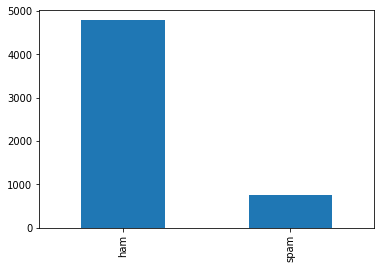

In [4]:
data['label'].value_counts().plot(kind='bar')

## Preprocessing the dataset

In [24]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

ham_words = []
for sms in data[data['label'] == 'ham'].sms:
    text = sms.lower()
    tokens = nltk.word_tokenize(text)
    # remove stop words
    filtered_tokens = [w.lower() for w in tokens if not w in stop_words and w.isalpha() and len(w) > 2]
    # filter with lemmatizer
    filtered_tokens = [lemmatizer.lemmatize(w) for w in filtered_tokens]
    ham_words.extend(filtered_tokens)
print(f'HAM {len(ham_words)}')

spam_words = []
for sms in data[data['label'] == 'spam'].sms:
    text = sms.lower()
    tokens = nltk.word_tokenize(text)
    # remove stop words
    filtered_tokens = [w.lower() for w in tokens if not w in stop_words and w.isalpha() and len(w) > 2]
    # filter with lemmatizer
    filtered_tokens = [lemmatizer.lemmatize(w) for w in filtered_tokens]
    spam_words.extend(filtered_tokens)
print(f'SPAM {len(spam_words)}')

ham_string=(' ').join(ham_words)
ham_wordcloud = WordCloud(width=500, height=300).generate(ham_string)

spam_string=(' ').join(spam_words)
spam_wordcloud = WordCloud(width=500, height=300).generate(spam_string)

[nltk_data] Downloading package punkt to /home/mantunes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mantunes/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/mantunes/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


HAM 32249
SPAM 8642


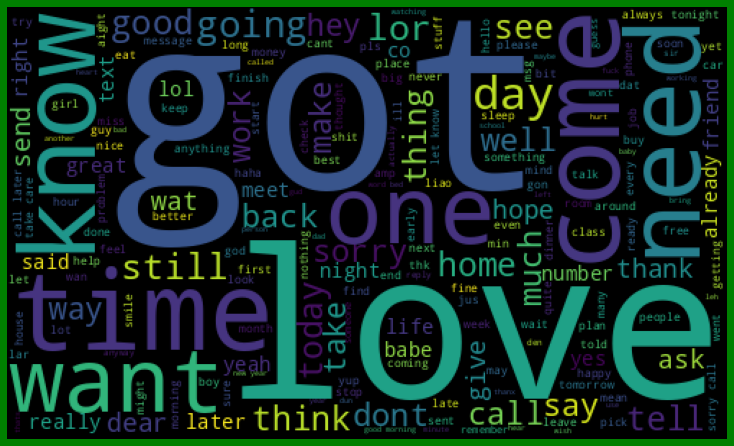

In [25]:
#Creating Ham wordcloud
plt.figure( figsize=(10,8), facecolor='g')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

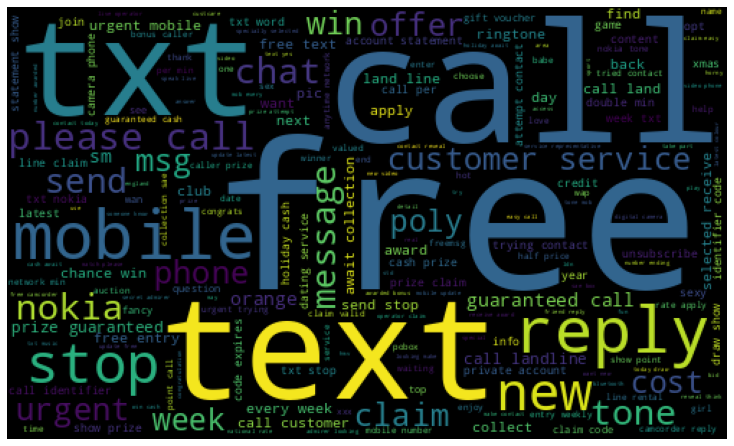

In [26]:
#Spam Word cloud
plt.figure( figsize=(10,8), facecolor='w')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [53]:
class NB:
    def __init__(self):
        self.p_spam = 0.0
        self.p_ham = 0.0
        self.spam_vocab = {}
        self.ham_vocab = {}
    
    def fit(self, ham_words, spam_words):
        total = len(ham_words)+len(spam_words)
        # compute prior
        self.p_spam = len(spam_words)/total
        self.p_ham = len(ham_words)/total
        
        # compute likelihood
        for word in spam_words:
            if word not in self.spam_vocab:
                self.spam_vocab[word] = 0.0
            self.spam_vocab[word] += 1
        for key in self.spam_vocab:
            self.spam_vocab[key] /= len(spam_words)
        
        for word in ham_words:
            if word not in self.ham_vocab:
                self.ham_vocab[word] = 0.0
            self.ham_vocab[word] += 1
        for key in self.ham_vocab:
            self.ham_vocab[key] /= len(spam_words)
        
    
    def predict(self, sms):
        text = sms.lower()
        tokens = nltk.word_tokenize(text)
        # remove stop words
        filtered_tokens = [w.lower() for w in tokens if not w in stop_words and w.isalpha() and len(w) > 2]
        # filter with lemmatizer
        filtered_tokens = [lemmatizer.lemmatize(w) for w in filtered_tokens]
        
        prob_likelihood_spam = 1.0
        prob_likelihood_ham = 1.0
        for word in filtered_tokens:
            if word in self.spam_vocab:
                pr_WS = self.spam_vocab[word]
            else:
                pr_WS = 0.0
            if word in self.ham_vocab:
                pr_WH = self.ham_vocab[word]
            else:
                pr_WH = 0.0
            prob_likelihood_spam *= pr_WS
            prob_likelihood_ham *= pr_WH
            #prob_word_is_spam_BAYES = (pr_WS*self.p_spam)/((pr_WS*self.p_spam)+(pr_WH*self.p_ham))
            #print(prob_word_is_spam_BAYES)
            #prob *= prob_word_is_spam_BAYES
        prob = self.p_spam*prob_likelihood_spam / (self.p_spam*prob_likelihood_spam + self.p_ham*prob_likelihood_ham)
        if prob >= 0.5:
            return True
        else:
            return False

    def __str__(self):
        return f'Prior ({self.p_ham}/{self.p_spam}) Vocab ({len(self.ham_vocab)}/{len(self.spam_vocab)})'

In [54]:
nb = NB()
nb.fit(ham_words, spam_words)
print(nb)

print(nb.predict('Ok lar... Joking wif u oni...'))
print(nb.predict('Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&Cs apply 08452810075over18s'))

Prior (0.7886576508278105/0.21134234917218947) Vocab (5657/1531)
False
True


In [62]:
data = data.replace(['ham','spam'],[False, True]) 
results = data.apply(lambda row : nb.predict(row['sms']) == row['label'], axis = 1)
acc = results.value_counts()[True]/results.count()
print(acc)

0.9940228219525449
